In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 随机数
torch.manual_seed(1)
np.random.seed(1)

In [3]:
# 学习率
LR_G = 0.0001
LR_D = 0.0001
# 样本数
BATCH_SIZE = 64
# 输入的噪声维度
N_IDEAS = 5
# 噪声输入后的输出维度
ART_COMPONETS = 15
# 原始数据的x坐标-1~1均匀分布
PAINT_POINTS = np.stack([np.linspace(-1, 1, ART_COMPONETS) for _ in range(BATCH_SIZE)], 0)

In [4]:
# 根据输入的 PAINT_POINTS（x 值），计算出对应的 y 值，并返回一个 PyTorch 张量
def artist_work():
    a = np.ones((BATCH_SIZE, 1)) * 2
    #paints = a * np.power(PAINT_POINTS, 2) + (a - 1)  # y = 2x^2 + 1
    paints = 2 * a * np.power(PAINT_POINTS, 3) + (a + 3)  # y = 4x^3 + 5
    paints = torch.from_numpy(paints).float()
    return paints

In [5]:
# 网络结构
G = nn.Sequential(
    nn.Linear(N_IDEAS, 256),
    nn.ReLU(),
    nn.Linear(256, ART_COMPONETS)
)
D = nn.Sequential(
    nn.Linear(ART_COMPONETS, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [6]:
# 优化器与损失函数
optimizer_G = torch.optim.Adam(G.parameters(), lr=LR_G)
optimizer_D = torch.optim.Adam(D.parameters(), lr=LR_D)
Criterion = torch.nn.BCELoss()

In [7]:
# 开始训练
plt.ion()
G_losses = []  # 储存了损失方便自己画图可视化
D_losses = []

训练结束


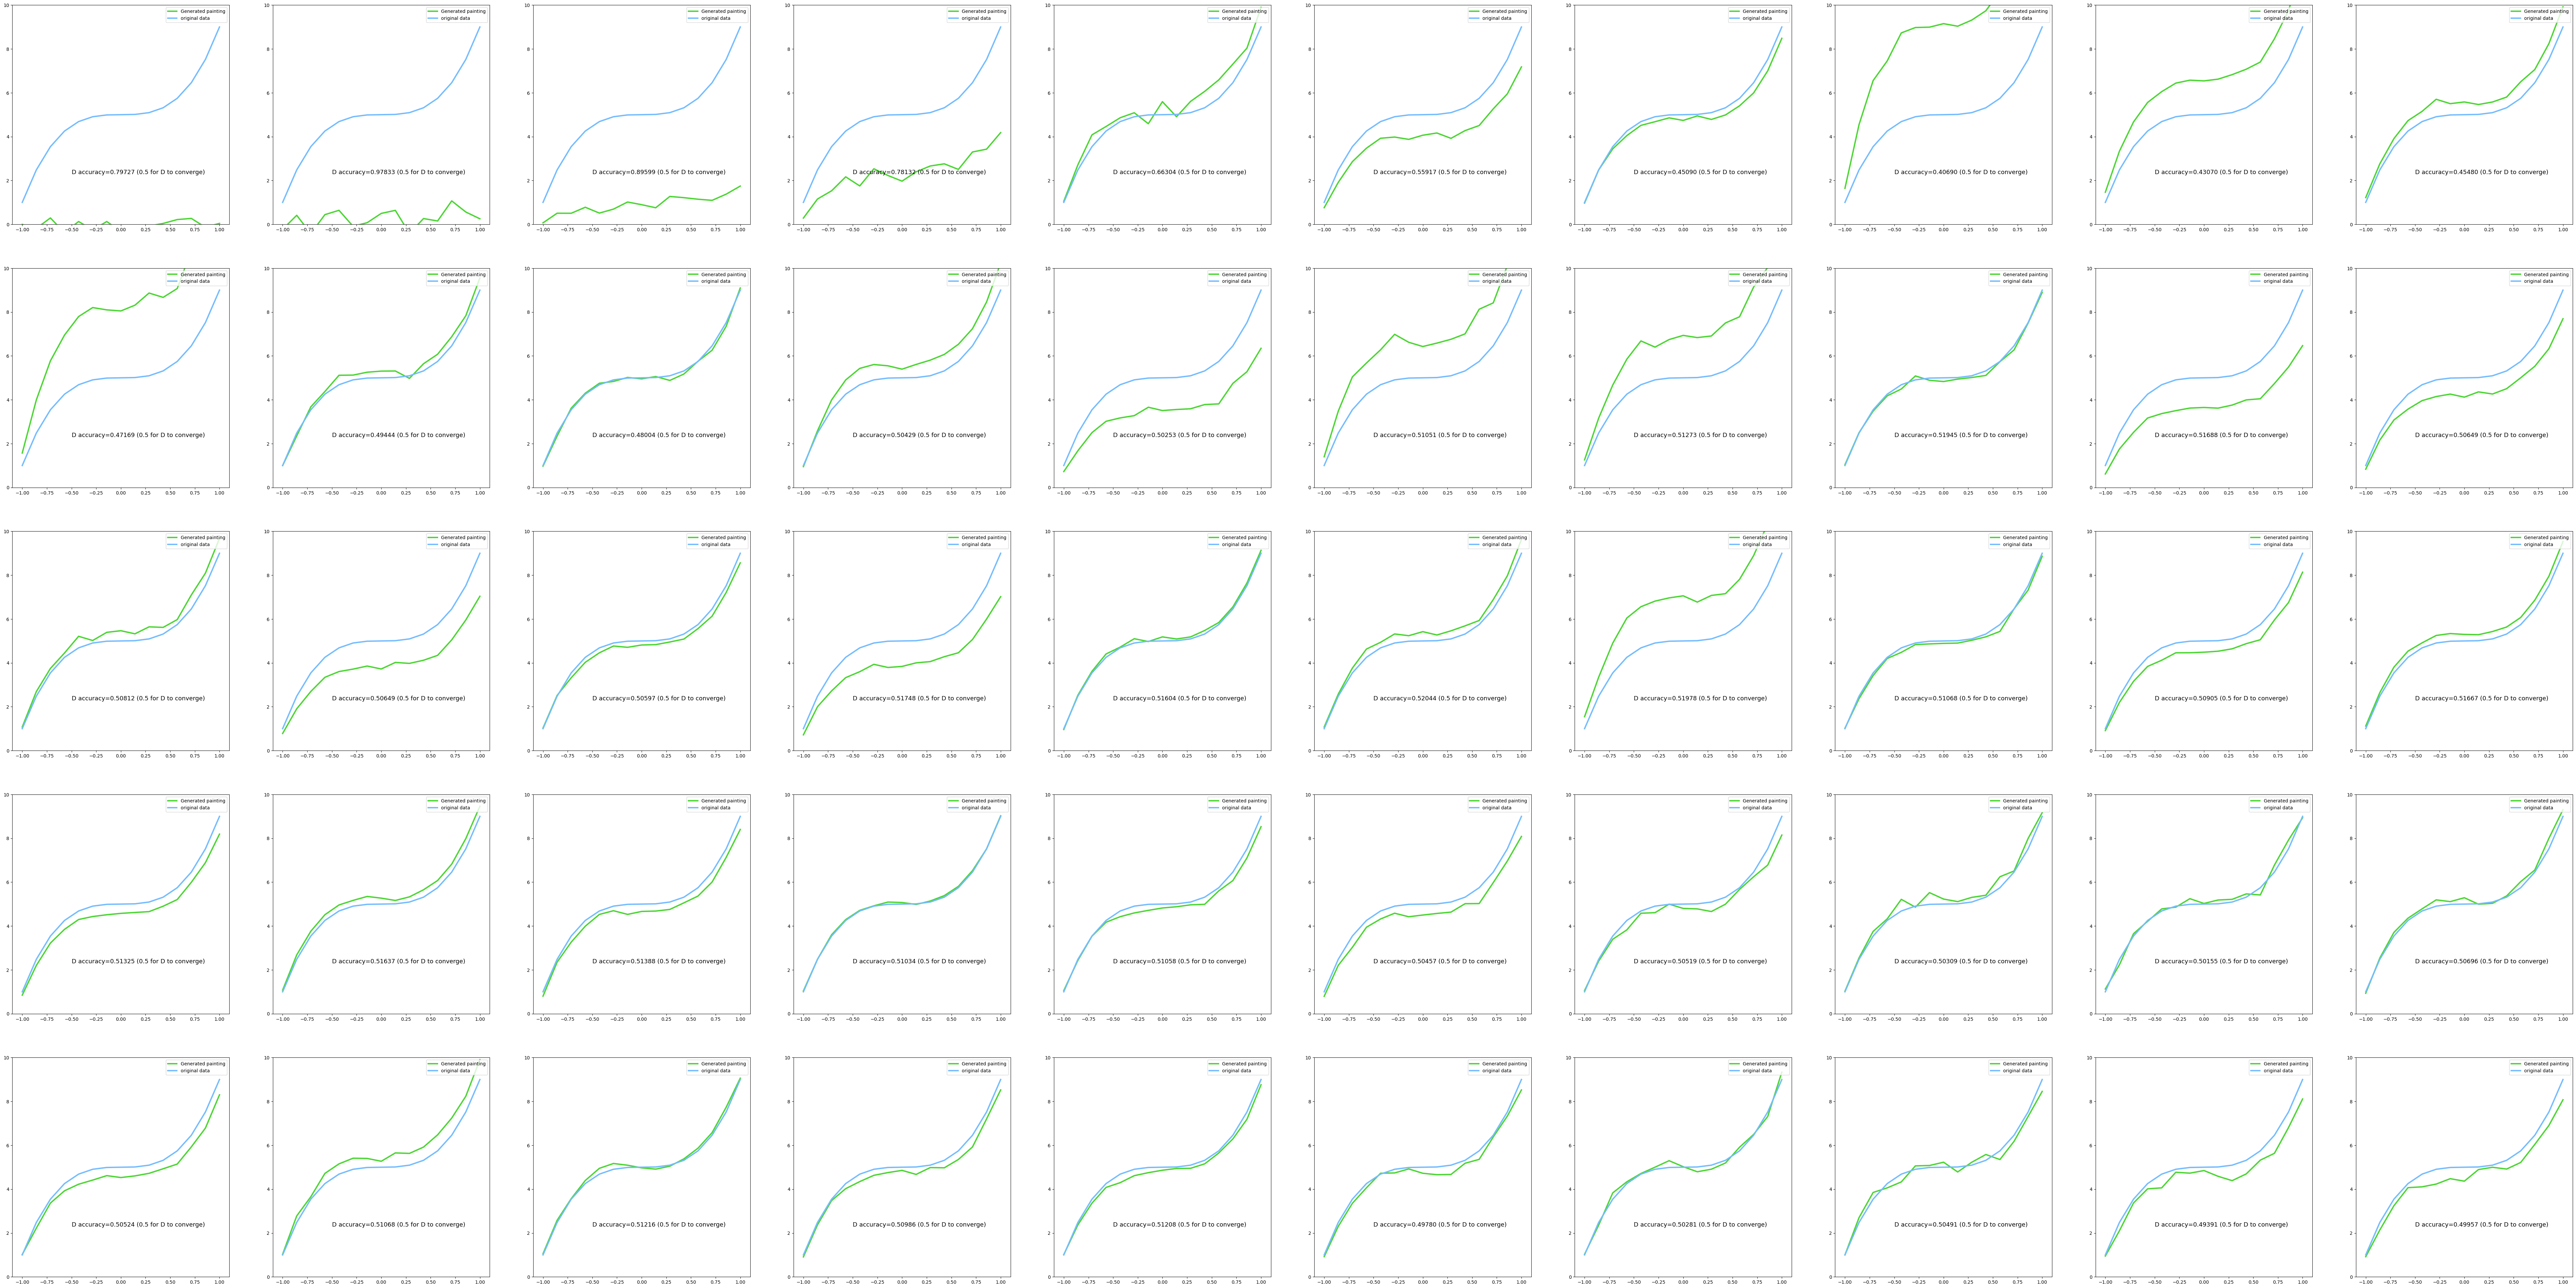

In [8]:
image_n = 0
plt.figure(figsize=(100, 50))
for step in range(10000):
    artist_painting = artist_work()
    G_idea = torch.randn(BATCH_SIZE, N_IDEAS)

    G_paintings = G(G_idea)

    pro_atrist0 = D(artist_painting)
    pro_atrist1 = D(G_paintings)

    # updata
    G_loss = -torch.mean(torch.log(pro_atrist1))
    G_losses.append(G_loss.item())
    #D_loss = Criterion(pro_atrist0, torch.ones_like(pro_atrist0)) + Criterion(pro_atrist1,
    #                                                                          torch.zeros_like(pro_atrist1))
    D_loss = -torch.mean(torch.log(pro_atrist0)) - torch.mean(torch.log(1. - pro_atrist1))
    D_losses.append(D_loss.item())
    optimizer_G.zero_grad()
    G_loss.backward(retain_graph=True)  # 因为D的反向传播需要用到G，所以设置为True

    optimizer_D.zero_grad()
    D_loss.backward()
    optimizer_G.step()
    optimizer_D.step()
    
    '''
    # 冻结生成器的参数
    for param in G.parameters():
        param.requires_grad = False

    # 解冻判别器的参数
    for param in D.parameters():
        param.requires_grad = True

    # 解冻生成器的参数
    for param in G.parameters():
        param.requires_grad = True

    # 冻结判别器的参数
    for param in D.parameters():
        param.requires_grad = False
    '''
    
    if step % 200 == 0:  # plotting
        ax = plt.subplot(5, 10, image_n+1)
        ax.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='Generated painting', )
        #ax.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='original data')
        ax.plot(PAINT_POINTS[0], 4 * np.power(PAINT_POINTS[0], 3) + 5, c='#74BCFF', lw=3, label='original data')
        ax.text(-.5, 2.3, 'D accuracy=%.5f (0.5 for D to converge)' % pro_atrist0.data.numpy().mean(),
                fontdict={'size': 13})
        #ax.text(-.5, 2, 'G_loss= %.5f ' % G_loss.data.numpy(), fontdict={'size': 13})
        ax.set_ylim((0, 10))
        ax.legend(loc='upper right', fontsize=10)
        image_n = image_n + 1

print('训练结束')
plt.show()